# distgen/cu_inj/vcc_image

Create particles from VCC image PVs from EPICS

In [1]:
import numpy as np
import json
import os

# Nicer plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# PV data

These are the essential PVs and snapshot data needed to produce the particles.

In [2]:
PVDATA = json.load(open('CAMR-IN20-186-2021-03-04T15-43-38-08-00.json'))
PVDATA.keys()

dict_keys(['CAMR:IN20:186:IMAGE', 'CAMR:IN20:186:N_OF_COL', 'CAMR:IN20:186:N_OF_ROW', 'CAMR:IN20:186:RESOLUTION', 'CAMR:IN20:186:RESOLUTION.EGU'])

In [3]:
# dummy caget function
def caget(pvname):
    val = PVDATA[pvname]
    if isinstance(val, list):
        val = np.array(val)
    return(val)

In [4]:
# Extract data

arr = caget('CAMR:IN20:186:IMAGE')
ncol = caget('CAMR:IN20:186:N_OF_COL')
nrow = caget('CAMR:IN20:186:N_OF_ROW')
RESOLUTION = caget('CAMR:IN20:186:RESOLUTION')
RESOLUTION_UNITS = caget('CAMR:IN20:186:RESOLUTION.EGU')
IMAGE = arr.reshape(nrow, ncol)
IMAGE.shape, nrow, ncol, RESOLUTION, RESOLUTION_UNITS

((480, 640), 480, 640, 9.0, 'um')

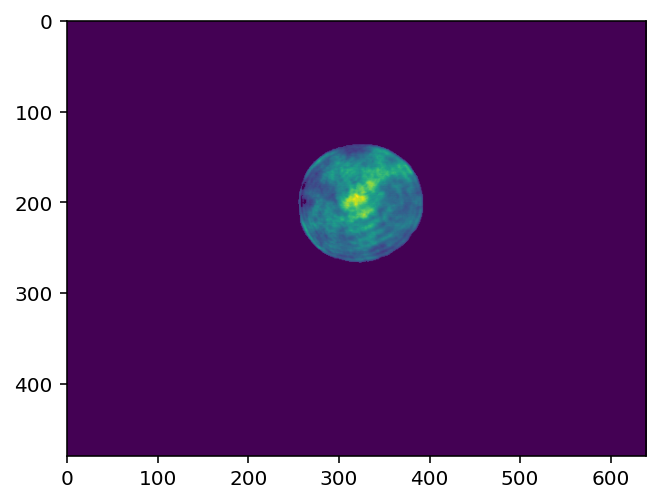

In [5]:
# The raw image
plt.imshow(IMAGE)

# Isolate the image

Region based segmentation adapted from:
https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html

In [6]:
from skimage.filters import sobel
from skimage.segmentation import watershed

In [7]:
def isolate_image(img):
    """
    Uses a masking technique to isolate the VCC image
    """
    img=img.copy()
    elevation_map = sobel(img)
    markers = np.zeros_like(img)
    
    # TODO: tweak these numbers
    markers[img < .1] = 1
    markers[img > .2] = 2

    # Wateshed
    segmentation = watershed(elevation_map, markers)
    
    img[np.where(segmentation != 2)]  = 0 
    
    # 
    ixnonzero0 = np.nonzero(np.sum(img, axis=1))[0]
    ixnonzero1 = np.nonzero(np.sum(img, axis=0))[0]
    
    i0, i1, j0, j1 = ixnonzero0[0], ixnonzero0[-1], ixnonzero1[0], ixnonzero1[-1]
    cutimg = img[i0:i1,j0:j1]
    
    return cutimg

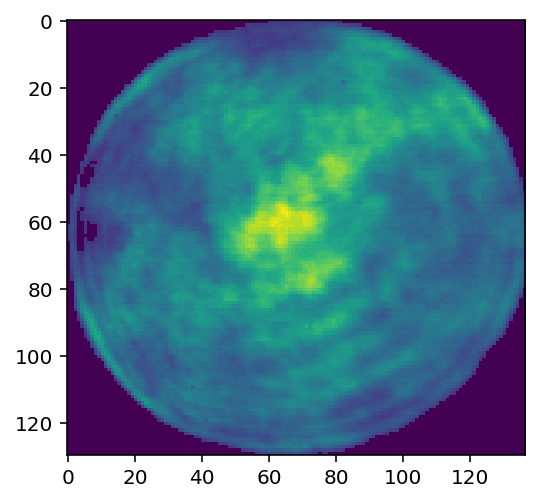

In [8]:
CUTIMG = isolate_image(IMAGE)

plt.imshow(CUTIMG)

# Create distgen xy_dist file

In [9]:
def write_distgen_xy_dist(filename, image, resolution, resolution_units='m'):
    """
    Writes image data in distgen's xy_dist format
    
    Returns the absolute path to the file written
    
    """
    
    # Get width of each dimension
    # header: 
    # x  x_range      <x>      [x units]  
    # y  y_range      <y>      [y units]  
    
    
    widths = resolution * np.array(image.shape)
    
    # Form header
    header = f"""x {widths[1]} {0} [{resolution_units}]
y {widths[0]} {0}  [{resolution_units}]"""
    
    # Save with the correct orientation
    np.savetxt(filename, np.flip(image, axis=0), header=header, comments='')
    
    return os.path.abspath(filename)

In [10]:
FOUT = write_distgen_xy_dist('laser_image.txt', CUTIMG, RESOLUTION, resolution_units=RESOLUTION_UNITS)

# Run distgen

In [11]:
from distgen import Generator

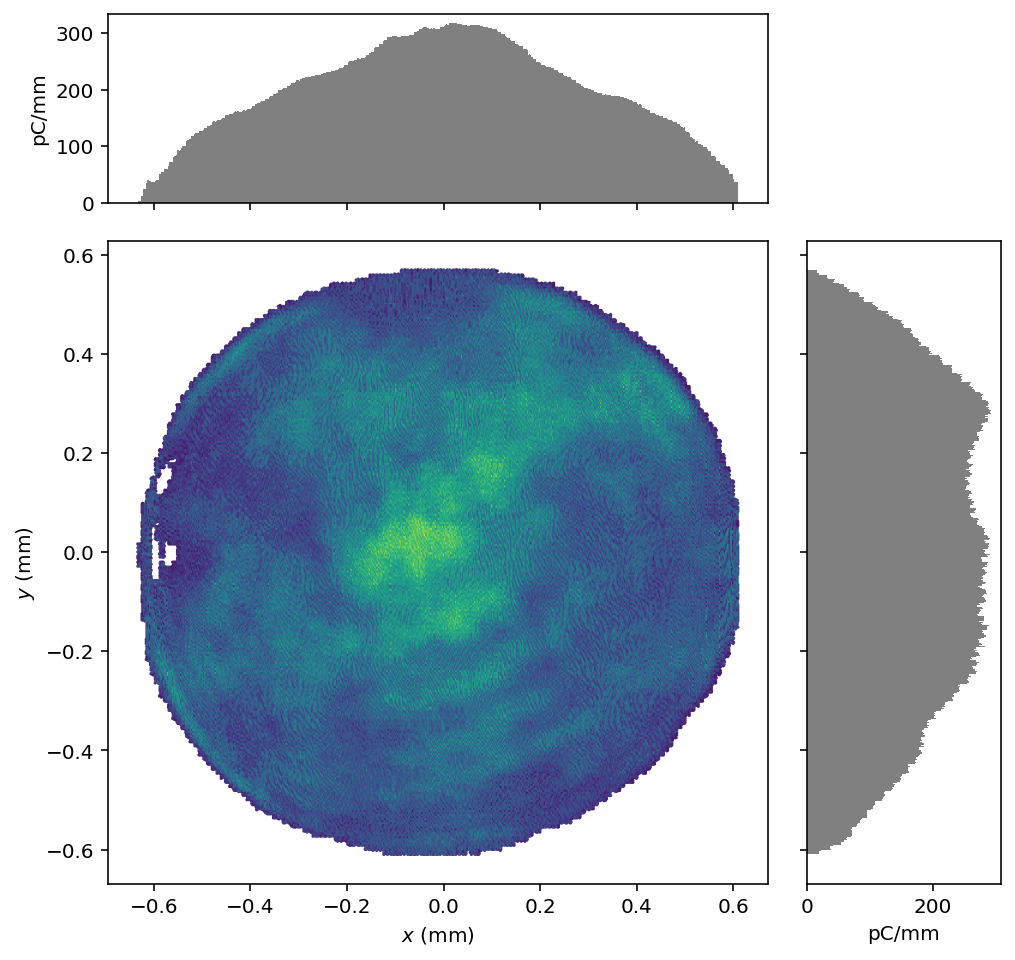

In [12]:
G = Generator('distgen.yaml')
G.run()
P = G.particles
P.plot('x', 'y', figsize=(8,8))

# Optional - Acquire from EPICS

In [ ]:
from epics import caget
import datetime

"""UTC to ISO 8601 with Local TimeZone information without microsecond"""
def isotime():
    return datetime.datetime.utcnow().replace(tzinfo=datetime.timezone.utc).astimezone().replace(microsecond=0).isoformat()   

In [ ]:
BASEPV = 'CAMR:IN20:186'

suffixes = {
    ':IMAGE': 'image array',
    ':N_OF_COL': 'start X',
    ':N_OF_ROW': 'Number of X pixels',
    ':RESOLUTION': 'size per pixel',
    ':RESOLUTION.EGU': 'units of size per pixel'
}
PVLIST = [BASEPV+s for s in suffixes]

PVDATA = {}
ISOTIME = isotime()
for name in PVLIST:
    val = caget(name)
    if isinstance(val, np.ndarray):
        val = val.tolist()
    PVDATA[name] = val

In [ ]:
FNAME = f'{BASEPV}-{ISOTIME}.json'
json.dump(PVDATA, open(FNAME, 'w'))
FNAME